# Handle spatial data 

In [14]:
import geopandas as gpd #Para archivos .shp 
import matplotlib.pyplot as plt #Para gráficar 
#Se define el tamaño de salidad de las gráficas

import numpy as np 
import pandas as pd

from shapely import wkt
import geopy.distance
from math import radians, cos, sin, asin, sqrt

from pandas.core.frame import DataFrame
from functools import reduce
import pyproj as pp
from pyproj import Proj


from pylab import rcParams 
rcParams['figure.figsize'] = 15,15

import warnings
warnings.filterwarnings('ignore')

## Handle spatial data of beneficiaries of non-contributory monetary transfers in Quito - MIES

In [2]:
#Database from MIES

# BDH and others pensions 
df_1 = pd.read_excel("https://info.inclusion.gob.ec/images/usuarios_externos/2023/bonos_pensiones_ago2023.xlsx", sheet_name= "PARTE 1 AGO2023",dtype={'dpa_prov': str})
df_2 = pd.read_excel("https://info.inclusion.gob.ec/images/usuarios_externos/2023/bonos_pensiones_ago2023.xlsx", sheet_name= "PARTE 2 AGO2023")
df_MIES = pd.concat([df_1, df_2], ignore_index=True)

df_ben = df_MIES.groupby(['dpa_desprov','beneficio'])['beneficio'].count().reset_index(name='Total_beneficiarios')
df_ben


,dpa_desprov,beneficio,Total_beneficiarios
0,AZUAY,BONO 1000 DIAS,1731
1,AZUAY,BONO DE DESARROLLO HUMANO,25914
2,AZUAY,BONO DE DESARROLLO HUMANO CON COMPONENTE VARIABLE,8903
3,AZUAY,BONO JOAQUIN GALLEGOS LARA,1280
4,AZUAY,PENSION MIS MEJORES AÑOS,14056
...,...,...,...
193,ZONA EN ESTUDIO,BONO DE DESARROLLO HUMANO CON COMPONENTE VARIABLE,427
194,ZONA EN ESTUDIO,PENSION MIS MEJORES AÑOS,423
195,ZONA EN ESTUDIO,PENSION PARA ADULTOS MAYORES,1
196,ZONA EN ESTUDIO,PENSION PARA PERSONAS CON DISCAPACIDAD,1


In [3]:
df_MIES_Quito = df_MIES[df_MIES['dpa_descan']=='DISTRITO METROPOLITANO DE QUITO']
df_MIES_Quito.head()

,zon_plan,uni_des_mi,dpa_prov,dpa_desprov,dpa_can,dpa_descan,dpa_par,dpa_despar,beneficio,edad,x,y,corte
320,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170162,GUANGOPOLO,PENSION MIS MEJORES AÑOS,94.0,-78.453238,-0.259818,ago 2023
424,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,83.0,-78.467887,-0.126370,ago 2023
461,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170111,GUAMANÍ,BONO JOAQUIN GALLEGOS LARA,95.0,-78.561417,-0.324848,ago 2023
985,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,76.0,-78.561565,-0.334326,ago 2023
1119,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,75.0,-78.571653,-0.330162,ago 2023


<Axes: >

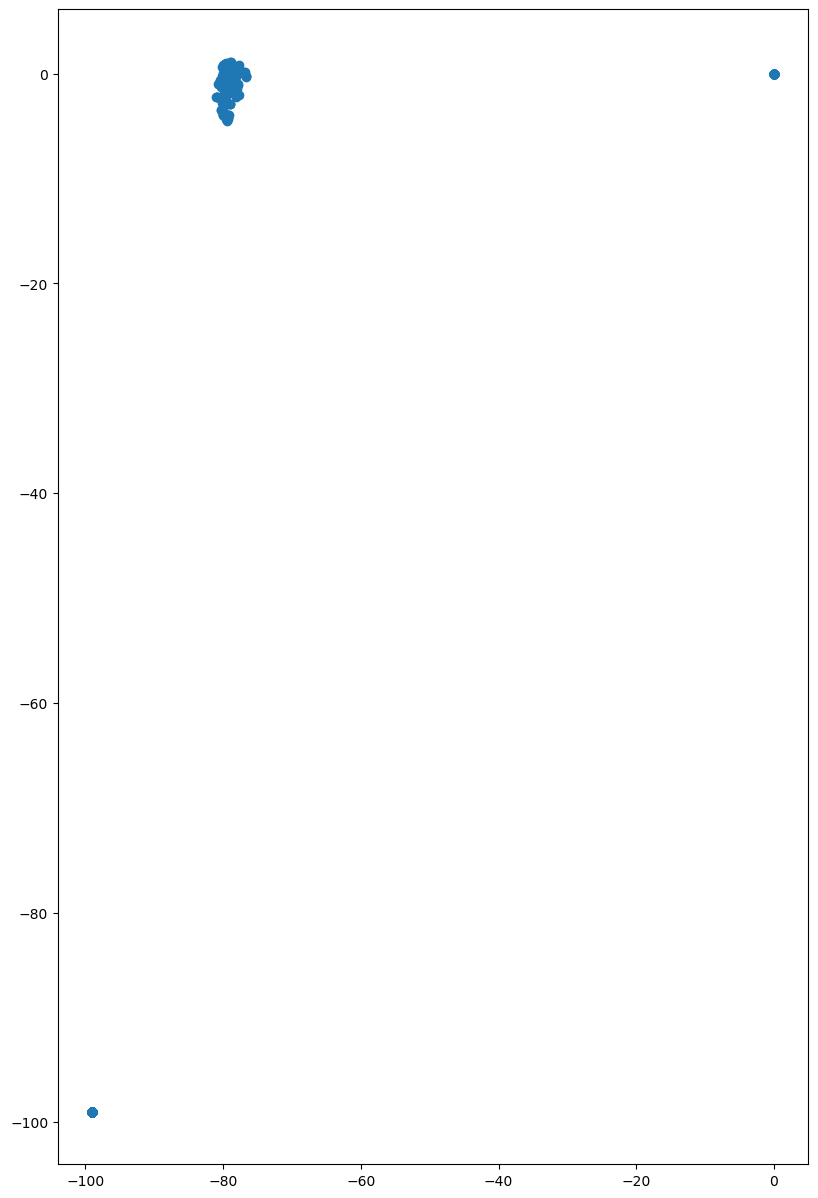

In [17]:
# Convert  MIES´s Database to spatial format "EPSG:4326"

df_MIES_Quito.dropna(subset=['x', 'y'], inplace= True)

df_MIES_gdf= gpd.GeoDataFrame(df_MIES_Quito, geometry= gpd.points_from_xy(df_MIES_Quito['x'],df_MIES_Quito['y']))
df_MIES_gdf['geometry'] = df_MIES_gdf['geometry'].astype(str).apply(wkt.loads)
gdf_hog = gpd.GeoDataFrame(df_MIES_gdf)

gdf_hog = gdf_hog.set_crs("EPSG:4326")
gdf_hog.plot()

MIES points have wrong geographical coor (points that are outside Quito), the following steps are performed:

1. The shapefile of Quito's Barrios is loaded and converted into the 4326 format (same geographic format as the MIES base)

In [18]:
df_barr= gpd.read_file("../data/Barrios Quito/BARRIO_REF.shp",encoding='ISO-8859-1') #Se lee la base de datos .Shp
df_barr= df_barr.to_crs("EPSG:4326")

2. Interception between beneficiaries of non-contributory monetary transfers and Quito's Barrios shapefile.

In [19]:
df_final = gpd.sjoin(gdf_hog,df_barr,how='left')
df_final.head(3)

,zon_plan,uni_des_mi,dpa_prov,dpa_desprov,dpa_can,dpa_descan,dpa_par,dpa_despar,beneficio,edad,...,geometry,index_right,id,codigo,parroquia,nombre,norte,sur,este,oeste
320,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170162,GUANGOPOLO,PENSION MIS MEJORES AÑOS,94.0,...,POINT (-78.45324 -0.25982),437.0,424.0,L_C040001,GUANGOPOLO,BARRIO CENTRAL,DELIMITACIÃN DE COMUNAS,LA RIVERA,DELIMITACIÃN DE COMUNAS,SAN JOSÃ DE OLEAS
424,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,83.0,...,POINT (-78.46789 -0.12637),927.0,923.0,L_D030007,COMITÃ DEL PUEBLO,COMITÃ DEL PUEBLO,"QUEBRADA S/N, CALLE MANUEL AMBROSI, BARRIO COL...","CALLE ANGEL SAENZ, CALLE JUAN MOLINEROS, CALLE...","QUEBRADA SAN ANTONIO, BARRIO LA BOTA","CALLE FRANCISCO DE LA TORRE, CALLE E13 JORGE ..."
461,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170111,GUAMANÍ,BONO JOAQUIN GALLEGOS LARA,95.0,...,POINT (-78.56142 -0.32485),108.0,120.0,QUI020023,GUAMANÃ,SAN VICENTE DE CORNEJO,QUEBRADA UGTUPUNGO,CALLE S54,CALLE FRANCISCO CAMPOS,QUEBRADA UGTUPUNGO


3. The points that are outside of Quito are eliminated

<Axes: >

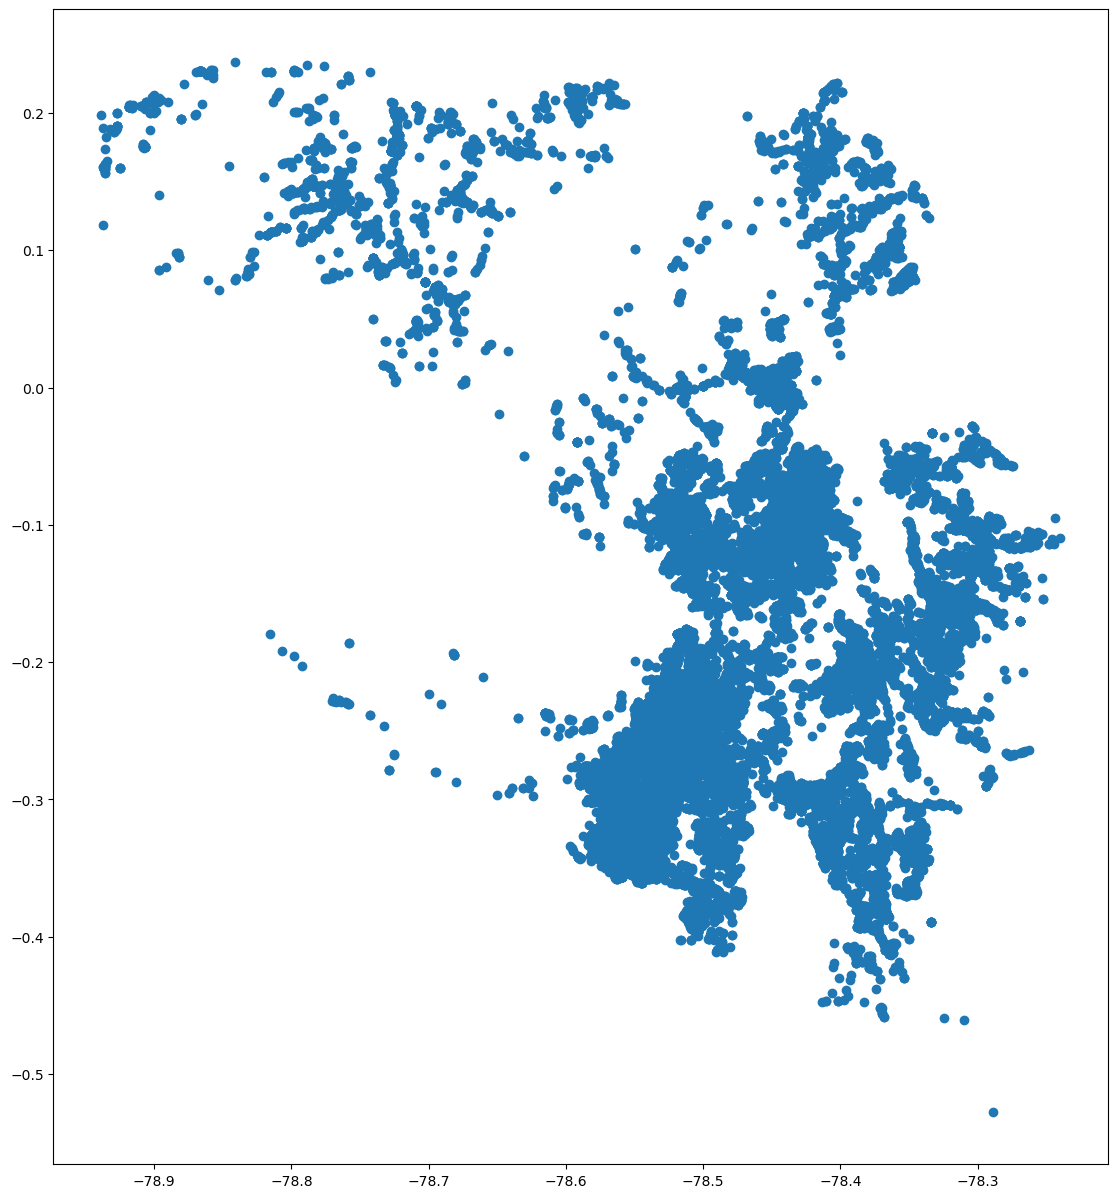

In [20]:
df_final.dropna(subset=['parroquia'], inplace = True )
df_final.plot()

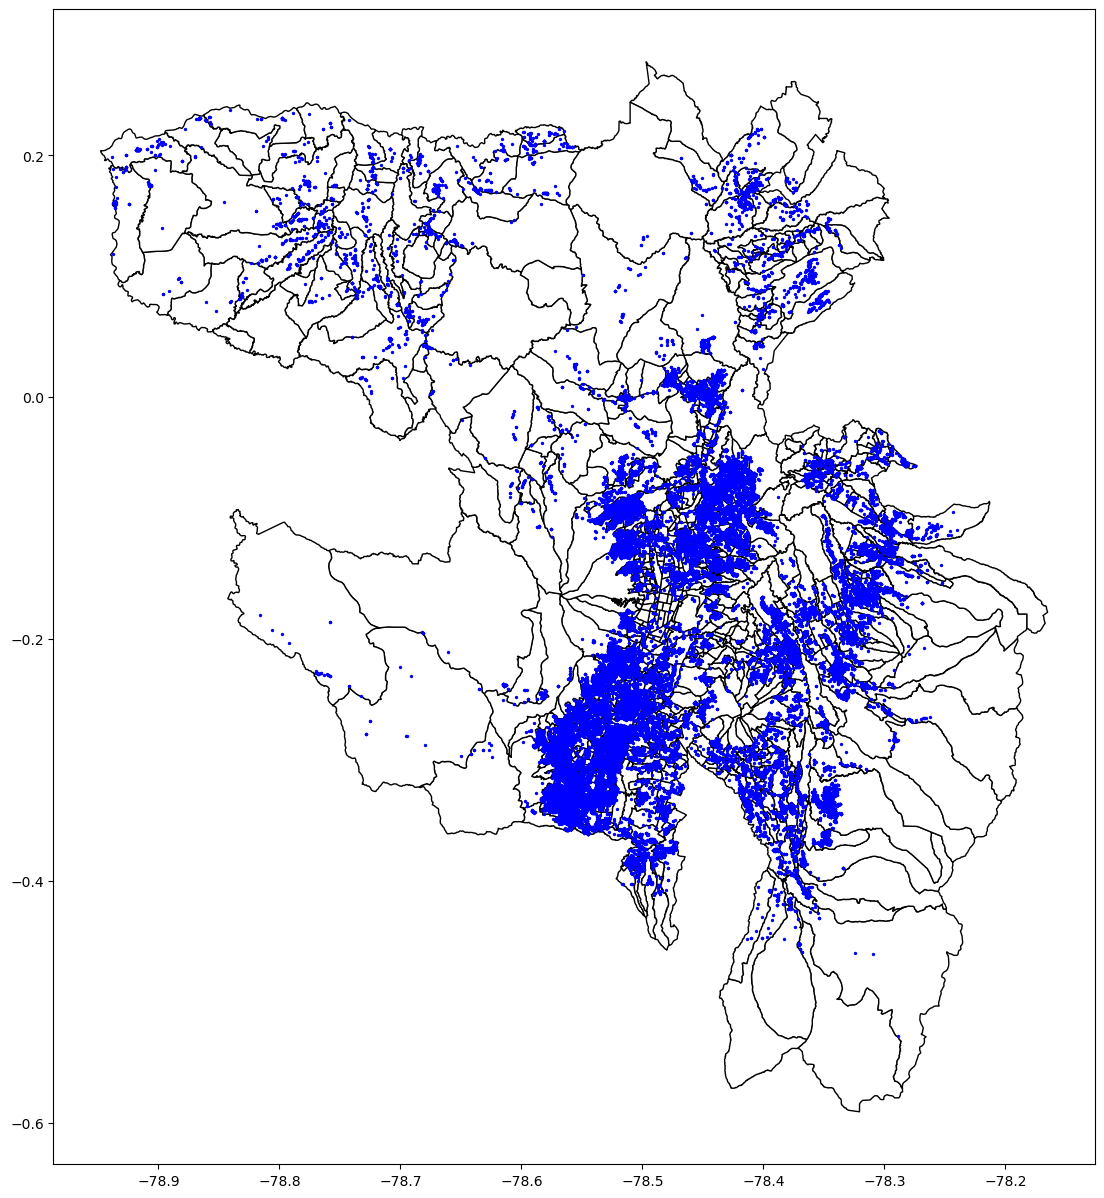

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_aspect('equal')
df_barr.plot(ax=ax, color='white', edgecolor='black')
df_final.plot(ax=ax, marker='o', color='blue', markersize=2)

plt.show()

In [22]:
df_final

,zon_plan,uni_des_mi,dpa_prov,dpa_desprov,dpa_can,dpa_descan,dpa_par,dpa_despar,beneficio,edad,...,geometry,index_right,id,codigo,parroquia,nombre,norte,sur,este,oeste
320,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170162,GUANGOPOLO,PENSION MIS MEJORES AÑOS,94.0,...,POINT (-78.45324 -0.25982),437.0,424.0,L_C040001,GUANGOPOLO,BARRIO CENTRAL,DELIMITACIÃN DE COMUNAS,LA RIVERA,DELIMITACIÃN DE COMUNAS,SAN JOSÃ DE OLEAS
424,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,83.0,...,POINT (-78.46789 -0.12637),927.0,923.0,L_D030007,COMITÃ DEL PUEBLO,COMITÃ DEL PUEBLO,"QUEBRADA S/N, CALLE MANUEL AMBROSI, BARRIO COL...","CALLE ANGEL SAENZ, CALLE JUAN MOLINEROS, CALLE...","QUEBRADA SAN ANTONIO, BARRIO LA BOTA","CALLE FRANCISCO DE LA TORRE, CALLE E13 JORGE ..."
461,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170111,GUAMANÍ,BONO JOAQUIN GALLEGOS LARA,95.0,...,POINT (-78.56142 -0.32485),108.0,120.0,QUI020023,GUAMANÃ,SAN VICENTE DE CORNEJO,QUEBRADA UGTUPUNGO,CALLE S54,CALLE FRANCISCO CAMPOS,QUEBRADA UGTUPUNGO
985,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,76.0,...,POINT (-78.56157 -0.33433),88.0,83.0,QUI020024,GUAMANÃ,SAN FERNANDO,"CALLE FRANCISCO CAMPOS, CALLE CLODOVEO CARRIÃN",CALLE MISAEL ACOSTA SOLÃS,CALLE OE4,CALLE OE7I
1119,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION MIS MEJORES AÑOS,75.0,...,POINT (-78.57165 -0.33016),103.0,99.0,QUI020011,GUAMANÃ,ESPERANZA Y PROGRESO DEL PUEBLO,18 DE OCTUBRE,SUREÃOS DE CORAZÃN,CALLE CAMILO OREJUELA,QUEBRADA MONJAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441526,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO N...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170155,CALDERON (CARAPUNGO),BONO DE DESARROLLO HUMANO,42.0,...,POINT (-78.44837 -0.09272),991.0,989.0,CLD010009,CALDERÃN,SAN LUIS CALDERÃN,CALLE GALO PLAZA LASSO,AV. CAP. GIOVANNI CALLES,AV. CARLOS MANTILLA,CALLE JAIME ROLDÃS AGUILERA
1441556,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,BONO DE DESARROLLO HUMANO CON COMPONENTE VARIABLE,38.0,...,POINT (-78.50727 -0.22487),573.0,560.0,M_S010011,CENTRO HISTÃRICO,SAN MARCOS,"CALLE MEJÃA, MARQUEZA DE SOLANDA Y AV. PICHINCHA",CALLE SUCRE,AV. PICHINCHA,CALLE JUAN JOSÃ FLORES
1441557,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170150,QUITO,PENSION TODA UNA VIDA,17.0,...,POINT (-78.50727 -0.22487),573.0,560.0,M_S010011,CENTRO HISTÃRICO,SAN MARCOS,"CALLE MEJÃA, MARQUEZA DE SOLANDA Y AV. PICHINCHA",CALLE SUCRE,AV. PICHINCHA,CALLE JUAN JOSÃ FLORES
1441564,Zona Planificación: Quito,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO SUR,17,PICHINCHA,1701,DISTRITO METROPOLITANO DE QUITO,170111,GUAMANÍ,BONO JOAQUIN GALLEGOS LARA,15.0,...,POINT (-78.55361 -0.34732),61.0,48.0,QUI020041,GUAMANÃ,LA FLORENCIA,CALLE S60B,CALLE S61E,AV. PEDRO VICENTE MALDONADO,CALLE PATRICIO ROMERO BARBERIS
